# Video Action Recognition with GluonCV


This tutorial demonstrates how to get started with GluonCV for Video Action Recognition task.



It contains examples of:

- Using pretrained models for inference
- How to train your own model

## Configuration

Install `GluonCV`, `mmcv` and `cv2` through `pip`. 

Optionally, install `MXNet` in case you haven't done so. 

In [15]:
#!pip install gluoncv==0.6.0b20191012
#!pip install mmcv
#!pip install opencv-python
#!pip install mxnet-cu100mkl 

    100% |████████████████████████████████| 51kB 1.2MB/s ta 0:00:011
    100% |████████████████████████████████| 28.7MB 1.6MB/s eta 0:00:01    57% |██████████████████▌             | 16.6MB 45.1MB/s eta 0:00:01    84% |███████████████████████████▏    | 24.3MB 55.9MB/s eta 0:00:01
  Running setup.py bdist_wheel for mmcv ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/46/30/a2/b2c6819a7bd47554b8c65c3210181611f32fcccb0f97b607dc
Successfully built mmcv
You are using pip version 10.0.1, however version 19.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Import necessary modules
import os, time, shutil, zipfile
import matplotlib.pyplot as plt
import numpy as np
import cv2

import mxnet as mx
from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms import video
from gluoncv.data import UCF101

import gluoncv
from gluoncv.utils import makedirs, download, LRSequential, LRScheduler, split_and_load, TrainingHistory
from gluoncv.model_zoo import get_model
from gluoncv.data.dataloader import tsn_mp_batchify_fn

## Predict with Pre-trained Models

We will show two exmaples here. For simplicity, we first try out a pre-trained UCF101 model on a single video frame. This is actually an image action recognition problem.

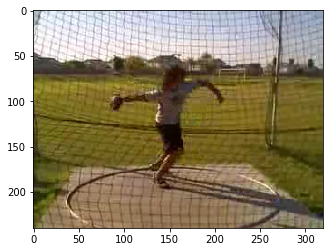

In [3]:
filename = 'ThrowDiscus.png'
img = mx.image.imread(filename)
plt.imshow(img.asnumpy())

In case you don’t recognize it, the image is a man throwing discus. 

Then choose a good model, load pre-trained weights with `pretrained=True`.

You can always find the one you like in this page:

https://gluon-cv.mxnet.io/model_zoo/action_recognition.html

In [4]:
model_name = 'vgg16_ucf101'
net = gluoncv.model_zoo.get_model(model_name, pretrained=True)

Model file is not found. Downloading.


100%|██████████| 500159/500159 [00:08<00:00, 61525.43KB/s]


Model file is not found. Downloading.


486864KB [00:07, 61954.32KB/s]                            


Now preprocess the image with the preset transformations.

In [5]:
transform_fn = transforms.Compose([
    video.VideoCenterCrop(size=224),
    video.VideoToTensor(),
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img_list = transform_fn([img.asnumpy()])

How does the transformed image look like?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


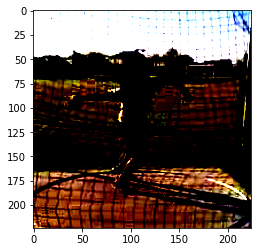

In [6]:
import numpy as np
plt.imshow(np.transpose(img_list[0], (1, 2, 0)))

The transformation does the following three things:

1. Center crop the image to 224x224 in size
2. Transpose it to C*H*W format
2. Normalizes the input image

With this, we can predict with one line of code:

In [7]:
pred = net(nd.array(img_list[0]).expand_dims(axis=0))

Check the top-5 predicted classes.

In [8]:
classes = net.classes
topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input video frame is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

The input video frame is classified to be
	[ThrowDiscus], with probability 0.998.
	[HorseRace], with probability 0.001.
	[VolleyballSpiking], with probability 0.001.
	[Hammering], with probability 0.000.
	[TennisSwing], with probability 0.000.


We can see that our pre-trained model predicts this video frame to be `throw discus` action with high confidence.

The next example is how to perform video action recognition, e.g., use the same pre-trained model on an entire video.

First, we read the video and sample the video frames at a speed of 1 frame per second.

![basketball_video](https://gluon-cv.mxnet.io/_static/action_basketball_demo.gif)

In [9]:
video_fname = 'v_Basketball_g01_c01.avi'

cap = cv2.VideoCapture(video_fname)
cnt = 0
video_frames = []
while(cap.isOpened()):
    ret, frame = cap.read()
    cnt += 1
    if ret and cnt % 25 == 0:
        video_frames.append(frame)
    if not ret: break

cap.release()
print('We evenly extract %d frames from the video %s.' % (len(video_frames), video_fname))

We evenly extract 5 frames from the video v_Basketball_g01_c01.avi.


Now we transform each video frame and feed them into the model. In the end, we average the predictions from multiple video frames to get a reasonable prediction.

In [10]:
video_frames_transformed = transform_fn(video_frames)
final_pred = 0
for _, frame_img in enumerate(video_frames_transformed):
    pred = net(nd.array(frame_img).expand_dims(axis=0))
    final_pred += pred
final_pred /= len(video_frames)

classes = net.classes
topK = 5
ind = nd.topk(final_pred, k=topK)[0].astype('int')
print('The input video is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(final_pred)[0][ind[i]].asscalar()))

The input video is classified to be
	[Basketball], with probability 0.978.
	[TennisSwing], with probability 0.020.
	[SoccerJuggling], with probability 0.002.
	[VolleyballSpiking], with probability 0.000.
	[JavelinThrow], with probability 0.000.


We can see that our pre-trained model predicts this video to be basketball action with high confidence. 

Note that, there are many ways to sample video frames and obtain a final video-level prediction.


## Training Your Own Action Recognition Model

We now show how to train a temporal segment networks (TSN) for video action recognition on UCF101 dataset. 


### Prepare Data

UCF101 is an action recognition dataset of realistic action videos, collected from YouTube. With 13,320 short trimmed videos from 101 action categories, it is one of the most widely used dataset in the research community for benchmarking state-of-the-art video action recognition models. Here, for demonstration purpose, we only sample a subset of UCF101 for training (one video per class). 

In [16]:
!python ucf101.py --tiny_dataset 

Decoding videos to frames.
Reading videos from folder:  ./UCF-101
Extension of videos:  avi
Total number of videos found:  101
[Warning] length inconsistent!Early stop with 892 out of 900 frames
Generating training files.
parsing frames under folder ./rawframes
frame folder analysis done


### Network Architecture

In [17]:
# number of GPUs to use
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]

# Get the model vgg16_ucf101 with temporal segment network, with 101 output classes, without pre-trained weights
net = get_model(name='vgg16_ucf101', nclass=101, tsn=True, num_segments=3)
net.collect_params().reset_ctx(ctx)
print(net)

ActionRecVGG16TSN(
  (basenet): ActionRecVGG16(
    (features): HybridSequential(
      (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Activation(relu)
      (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Activation(relu)
      (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
      (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): Activation(relu)
      (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): Activation(relu)
      (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
      (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Activation(relu)
      (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): Activation(relu)
      (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): Activati

### Data Augmentation and Data Loader

Data augmentation for video is different from image. For example, if you want to randomly crop a video sequence, you need to make sure all the video frames in this sequence undergo the same cropping process. We provide a new set of transformation functions, working with multiple images.

In [18]:
transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.875, 0.75, 0.66]),
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

With the transform functions, we can define data loaders for our training datasets.

In [27]:
# Batch Size for Each GPU
per_device_batch_size = 8
# Number of data loader workers
num_workers = 8
# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus if num_gpus > 0 else per_device_batch_size

# Set train=True for training data. Here we only use a subset of UCF101 for demonstration purpose.
# The subset has 101 training samples, one sample per class.
train_dataset = UCF101(root='./rawframes', setting='./ucfTrainTestlist/ucf101_train_split_2_rawframes.txt', train=True, num_segments=3, transform=transform_train)
print('Load %d training samples.' % len(train_dataset))

Load 101 training samples.


When temporal segment option is turned on, the training samples from train_dataset have a dimention of `num_segments x 3 x 224 x 224`. Hence, we can’t use default batchify function because we already have a batch dimention. We modify the default batchify function to `tsn_mp_batchify_fn`, basically changing `nd.stack` to `nd.concat`.

In [28]:
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers, batchify_fn=tsn_mp_batchify_fn)

### Optimizer, Loss and Metric

In [29]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [30, 60, np.inf]

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.001, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

# Define our loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

# Define the metric
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])

### Training

Finally we can start our training!In order to finish the tutorial quickly, we only train for 3 epochs on the tiny subset. In your experiments, we recommend setting epochs=80 for the full UCF101 dataset.

[Epoch 0] train=0.009901 loss=484.484331 time: 30.409381
[Epoch 1] train=0.059406 loss=453.620066 time: 14.048501
[Epoch 2] train=0.168317 loss=417.583248 time: 14.079453


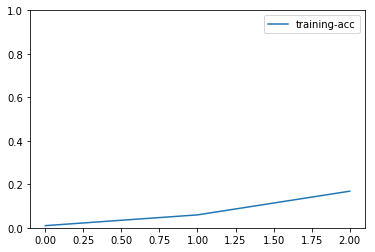

In [30]:
epochs = 3
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0, multiplier=3)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [net(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.sum().asscalar() for l in loss])
        train_metric.update(label, output)

    name, acc = train_metric.get()
    print('[Epoch %d] train=%f loss=%f time: %f' % (epoch, acc, train_loss, time.time()-tic))

    # Update history and print metrics
    train_history.update([acc])
    
# We can plot the metric scores with:
train_history.plot()

Although this is a small example, we can extend it to train a bigger model on much larger dataset. More tutorials can be found on our website.

## More resources

On the GluonCV Video Action Recognition Model Zoo page, we provide:

- Training scripts for UCF101, Kinetics400 and Something-Something-v2 datasets.
- Training hyperparameters to reproduce.
- Training Logs to compare speed and accuracy.